# Intro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import pyccl as ccl
import astropy.table as tbl
import os
import emcee
from scipy.optimize import minimize
import corner
import pickle

In [2]:
nEbins = 3 # Number of energy bins
nzbins = 6 # Number of galaxy redshift bins
nls = 7 # Number of cl data points

rker_z_min = 0.002 # Minimum redshift for neutrino radial kernel
rker_z_max = 0.6 # Maximum redshift for neutrino radial kernel
rker_z_n = 1024 # Number of redshift/radial distance values in neutrino radial kernel
gal_z_dir = 'GalZDist'  # Directory containing redshift distribuitons of each galaxy map
bzs = [1.182, 1.086, 1.126, 1.144, 1.206, 1.548] # Bias values for each galaxy map from arxiv:1805.11525

run_mcmc = False # Whether to run MCMC (True) or load pre-ran samplers from disk (False)
mcmc_chain_dir = 'MCMCChains' # Directory containing MCMC samplers
nwalkers = 8 # Number of walkers in MCMC sampling
npars = 2 # Number of free parameters in MCMC sampling
nsamples = 10000 # Number of samples in MCMC sampling

# xCell Power Spectra (Data)

In [3]:
# Loads in data, only keeps first 7 data points to match previous calculations
s = sacc.Sacc.load_fits('icecube_xcell/cls_cov.fits')
s.remove_selection(ell__gt=352)

In [4]:
# Finds ls, cls, and covs for each energy/redshift bin combination
xcell_l = np.empty((nEbins, nzbins, nls))
xcell_cl = np.empty((nEbins, nzbins, nls))
xcell_cov = np.empty((nEbins, nzbins, nls, nls))
xcell_icov = np.empty((nEbins, nzbins, nls, nls))
for i in range(nEbins):
    for j in range(nzbins):
        # For each cross-correlation
        xcell_l[i,j], xcell_cl[i,j], xcell_cov[i,j] = s.get_ell_cl('cl_00', f'IceCube__{i}', 
                                                                   f'LOWZ__{j}', return_cov=True)
        xcell_icov[i,j] = np.linalg.inv(xcell_cov[i,j])

# Theoretical Power Spectra (Model)

In [5]:
# Sets cosmological model
cosmo = ccl.CosmologyVanillaLCDM(transfer_function='eisenstein_hu')

In [6]:
# Loads in galaxy redshift distributions into astropy tables
gal_z_filenames = sorted(os.listdir(gal_z_dir))

gal_z_dist = []
for i in gal_z_filenames:
    gal_z_dist.append(tbl.Table.read(gal_z_dir + '/' + i, format = 'ascii'))

In [7]:
# Creates tracer for each galaxy redshift bin
gal_tracers = []
for i in range(len(gal_z_dist)):
    z = np.array(gal_z_dist[i]['col1'])
    nz = np.array(gal_z_dist[i]['col2'])
    bz = np.full(len(z), bzs[i])
    gal_tracers.append(ccl.NumberCountsTracer(cosmo, has_rsd=False, 
                                              dndz=(z, nz), bias=(z, bz)))

In [8]:
# Finds array of radial distances (chi) of radial kernel
chi_min = ccl.comoving_radial_distance(cosmo, 1./(1+rker_z_min))
chi_max = ccl.comoving_radial_distance(cosmo, 1./(1+rker_z_max))
chi_arr = np.linspace(chi_min, chi_max, rker_z_n)

# Converts radial distance array to inverse scale factor array (i.e. 1+z)
inv_a_arr = 1/ccl.scale_factor_of_chi(cosmo, chi_arr)

In [9]:
# Generates neutrino tracer
def generate_nu_tracer(cosmo, A, alpha, 
                       inv_a_arr=inv_a_arr):
    # cosmo - cosmological model to use
    # A - constant of proportionality in neutrino radial kernel
    # alpha - index of power in neutrino radial kernel
    # z_min - minimum redshift for neutrino radial kernel
    # z_max - maximum redshift for neutrino radial kernel
    # nchi - number of redshift/radial distance values in neutrino radial kernel

    # Uses chosen A and alpha to find final array of radial kernel
    rker_arr = A*(inv_a_arr)**alpha

    # Adds radial kernel to tracer
    nu_tracer = ccl.Tracer()
    nu_tracer.add_tracer(cosmo, kernel = (chi_arr, rker_arr))
    return nu_tracer

In [10]:
# Finds theoretical/model power spectra using neutrino radial kernel of the form A*(1+z)^alpha
def model(ells, A, alpha, gal_tracer):
    #ells - l values to calculate cls for
    # A - constant of proportionality in neutrino radial kernel
    # alpha - index of power in neutrino radial kernel
    # gal_tracer - galaxy tracer to use (i.e. which redshift bin)
    
    nu_tracer = generate_nu_tracer(cosmo, A, alpha)
    cl_cross = ccl.angular_cl(cosmo, nu_tracer, gal_tracer, ells)
    
    return cl_cross

# Chi-squared

In [11]:
# Finds chi squared of given data and model
def chi2(p, ells, d, icov, gal_tracer):
    # p - parameters to use in model
    # ells - l values to calculate cls for
    # d - cls of xCell data
    # icov - inverse covariance matrix of xCell data
    # gal_tracer - galaxy tracer to use (i.e. which redshift bin)
    
    A, alpha = p
    mod = model(ells, A, alpha, gal_tracer)
    r = d-mod
    
    return np.dot(r, np.dot(icov, r))

In [12]:
# Finds 'best fit' values of A, alpha for each cross-correlation
A_BF = np.empty((nEbins, nzbins))
alpha_BF = np.empty((nEbins, nzbins))

# Constrains alpha to avoid overflow errors with large values
bounds = [(None,None), (None,100)]

for i in range(nEbins):
    for j in range(nzbins):
        A_BF[i,j], alpha_BF[i,j] = minimize(chi2, (1,1), args=(xcell_l[i,j], xcell_cl[i,j], xcell_icov[i,j], 
                                                               gal_tracers[j]), bounds=bounds).x

In [13]:
# Finds chi squared with priors baked in
def chi2_with_prior(p, ells, d, icov, gal_tracer):
    # p - parameters to use in model
    # ells - l values to calculate cls for
    # d - cls of xCell data
    # icov - inverse covariance matrix of xCell data
    # gal_tracer - galaxy tracer to use (i.e. which redshift bin)
    
    # Only return non inf when mod(A) <= 0.1 and mod(alpha) <= 10
    if (np.fabs(p[0]) > 0.1) or (np.fabs(p[1]) > 10):
        return np.inf
    return chi2(p, ells, d, icov, gal_tracer)

# MCMC

In [14]:
if run_mcmc:    
    sampler = []
    chain = []
    # For each cross-correlation
    for i in range(nEbins):
        sampler.append([])
        chain.append([])
        for j in range(nzbins):
            # Starting position of MCMC walkers
            pos = ([A_BF[i,j], alpha_BF[i,j]] +
                   0.001 * np.random.randn(nwalkers, npars))

            # Creates MCMC sampler
            sampler[i].append(emcee.EnsembleSampler(nwalkers, npars, 
                                                    lambda p: -0.5*chi2_with_prior(p, xcell_l[i,j], 
                                                                                   xcell_cl[i,j], 
                                                                                   xcell_icov[i,j], 
                                                                                   gal_tracers[j])))
            
            # Runs MCMC and gets resulting chain (discarding first 20%, 'burn in' phase)
            sampler[i][j].run_mcmc(pos, nsamples)
            chain[i].append(sampler[i][j].get_chain(flat=True, discard=int(0.2*nsamples)).T)
            print(i,j)
    
    # Saves chains in pickle format
    with open(mcmc_chain_dir + '/MCMCChains', 'wb') as fp:
        pickle.dump(chain, fp)

else:
    # Loads samplers from disk - TEST PICKLING OF CHAINS WORKS BEFORE USING
    with open(mcmc_chain_dir + '/MCMCChains', 'rb') as fp:
        chain = pickle.load(fp)

# Plots

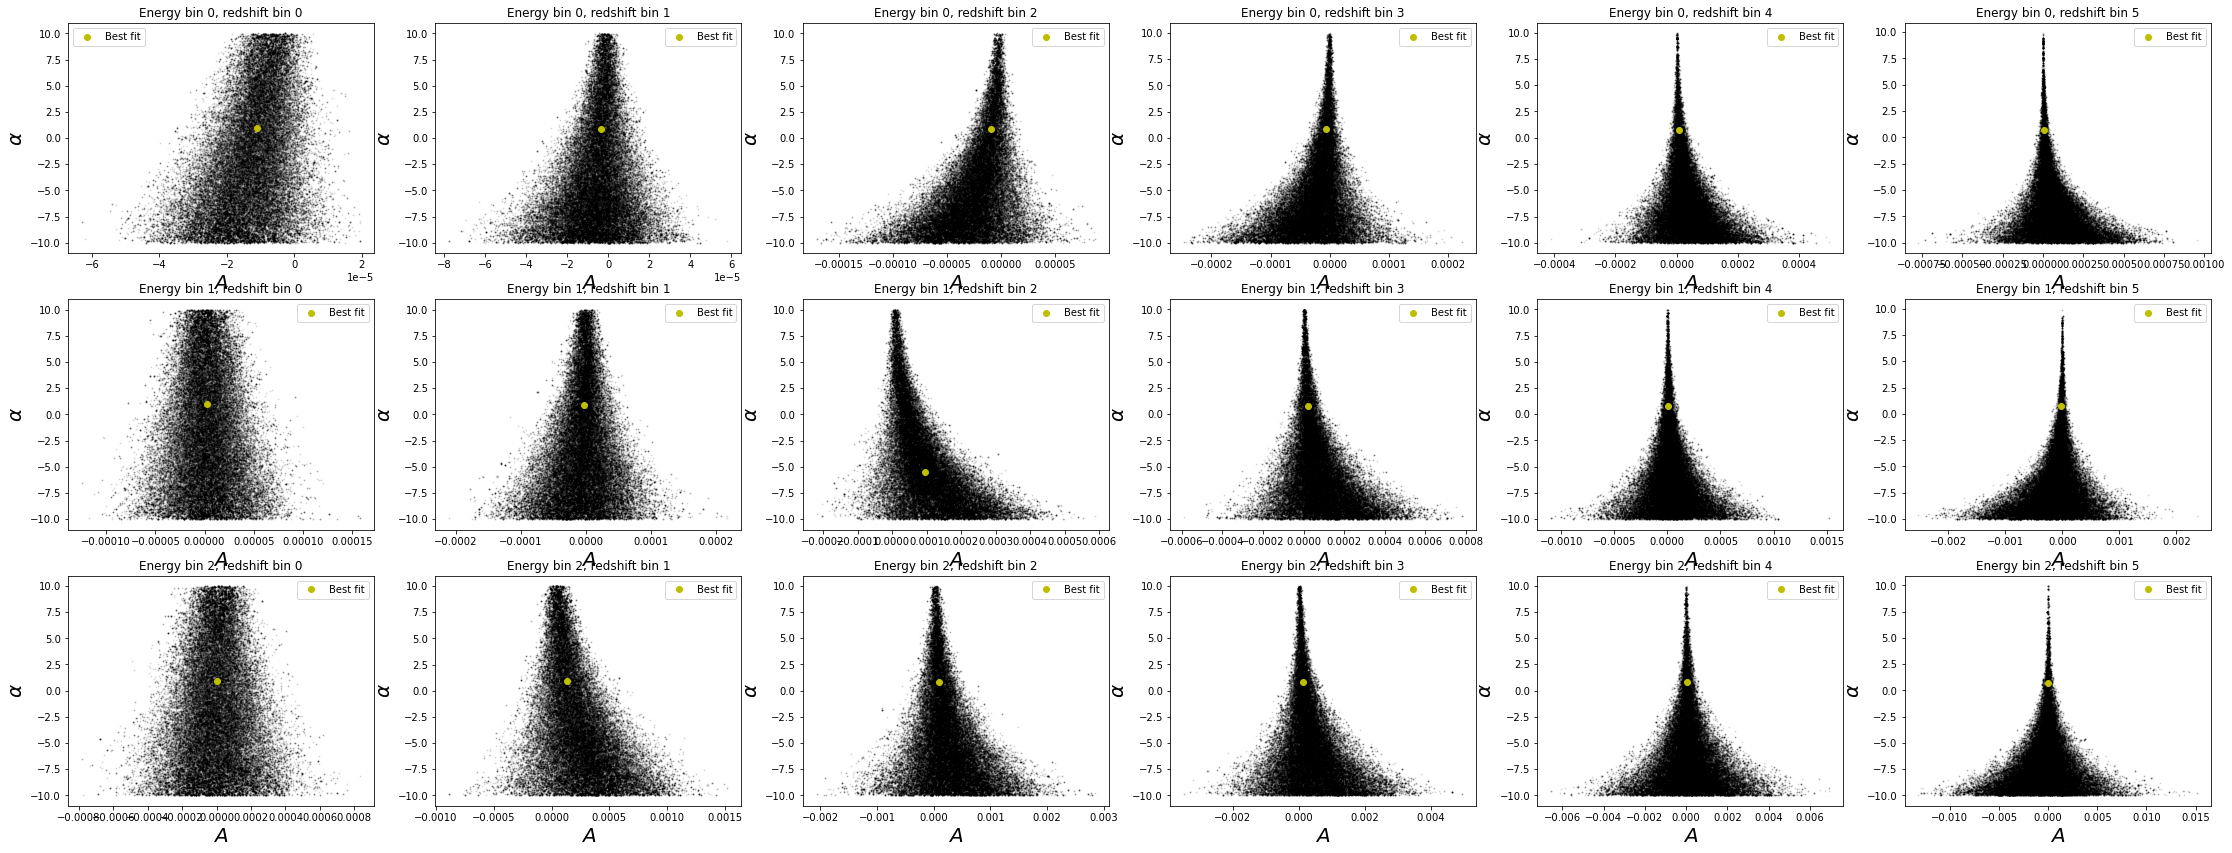

In [31]:
# Creates grid of subfigures
fig, axs = plt.subplots(nEbins, nzbins, 
                        figsize = (6.4*nzbins, 4.8*nEbins))

# Calculates chains and plots 2D histogram
for i in range(nEbins):
    for j in range(nzbins):
        axs[i,j].scatter(chain[i][j][0], chain[i][j][1], c='k', s=1, alpha=0.1)
        axs[i,j].plot(A_BF[i,j], alpha_BF[i,j], 'yo', label='Best fit')
        axs[i,j].set_title(f'Energy bin {i}, redshift bin {j}')
        axs[i,j].set_ylabel(r'$\alpha$', fontsize=20)
        axs[i,j].set_xlabel(r'$A$', fontsize=20)
        axs[i,j].legend()

plt.savefig('MCMC2DHistogram.svg')

Energy bin 0, redshift bin 0


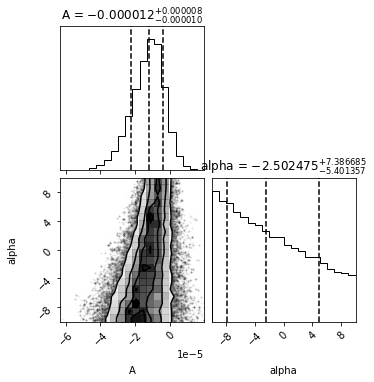

Energy bin 0, redshift bin 1


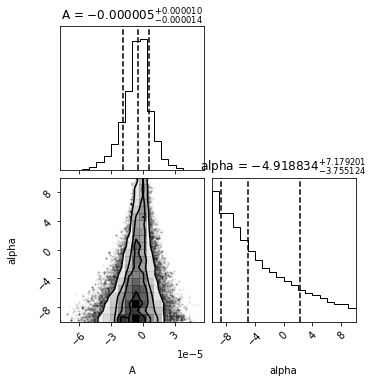

Energy bin 0, redshift bin 2


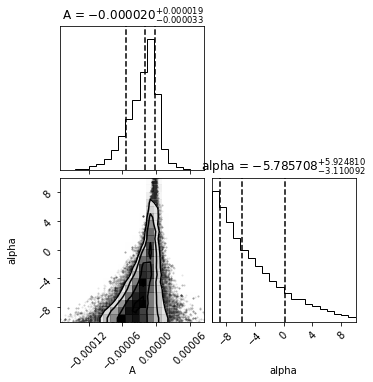

Energy bin 0, redshift bin 3


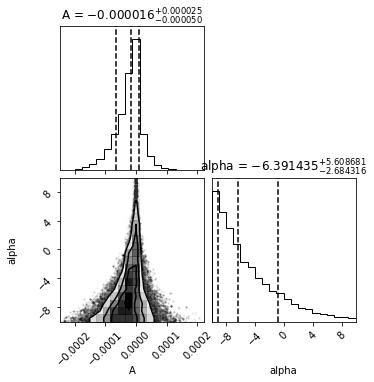

Energy bin 0, redshift bin 4


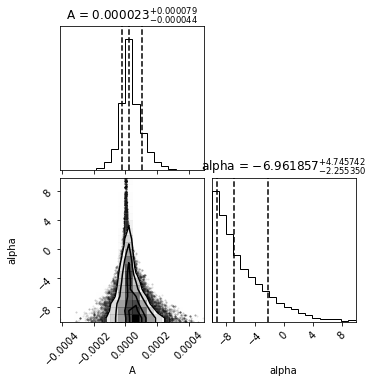

Energy bin 0, redshift bin 5


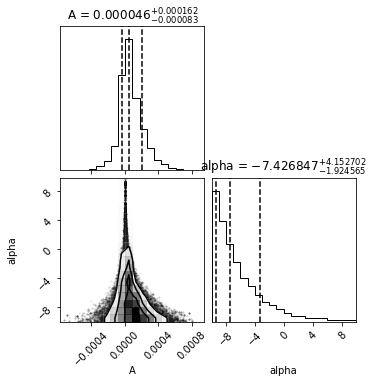

Energy bin 1, redshift bin 0


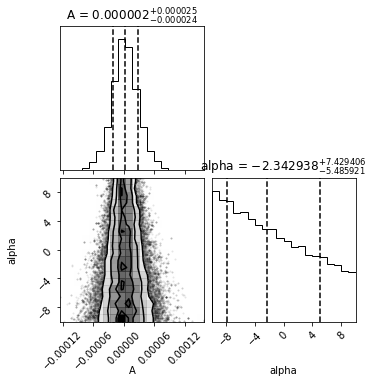

Energy bin 1, redshift bin 1


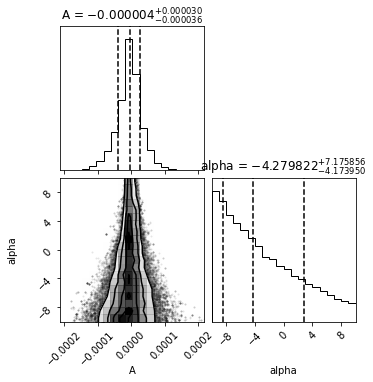

Energy bin 1, redshift bin 2


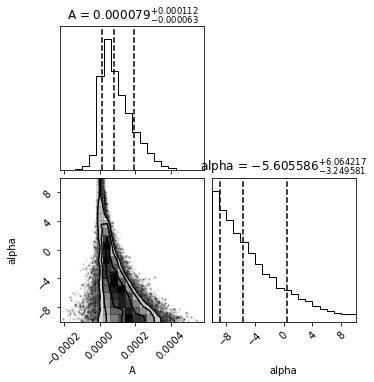

Energy bin 1, redshift bin 3


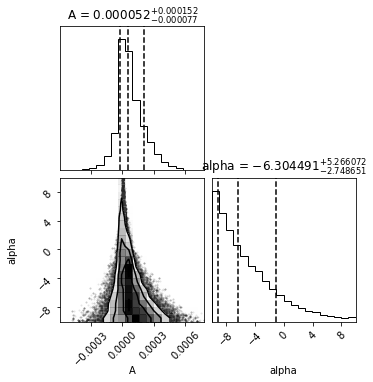

Energy bin 1, redshift bin 4


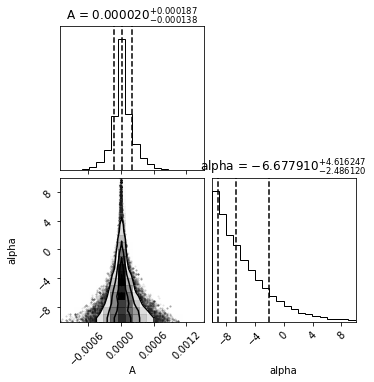

Energy bin 1, redshift bin 5


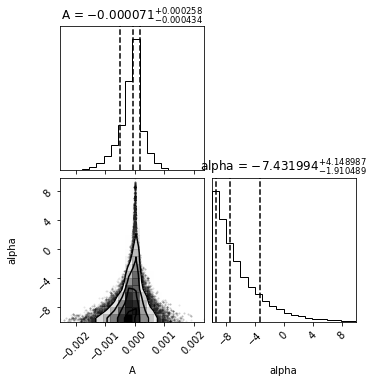

Energy bin 2, redshift bin 0


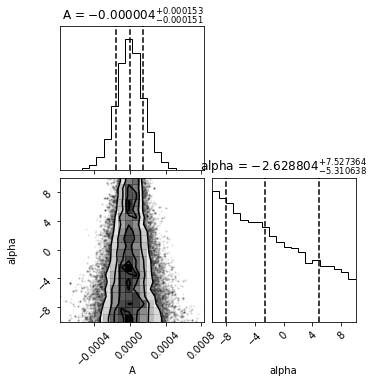

Energy bin 2, redshift bin 1


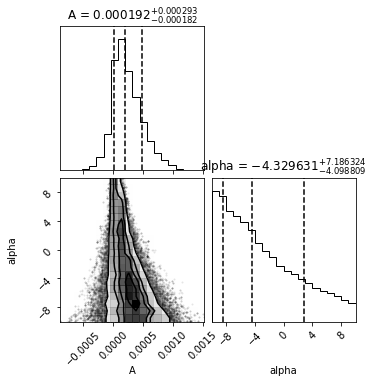

Energy bin 2, redshift bin 2


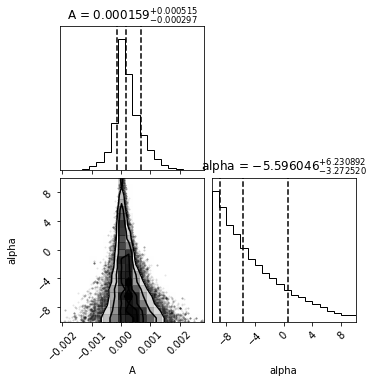

Energy bin 2, redshift bin 3


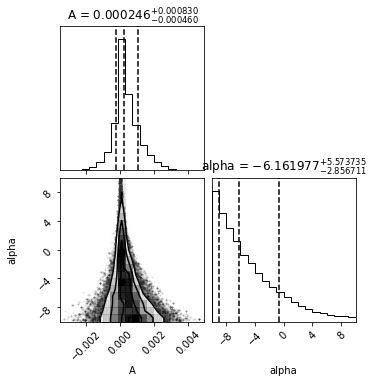

Energy bin 2, redshift bin 4


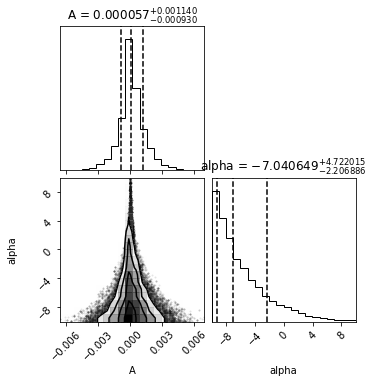

Energy bin 2, redshift bin 5


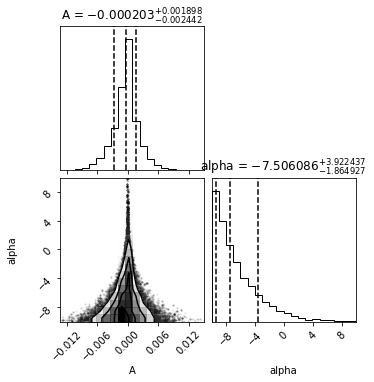

In [16]:
# Plots corner plots for each cross-correlation
for i in range(nEbins):
    for j in range(nzbins):
        print(f'Energy bin {i}, redshift bin {j}')
        corner.corner(chain[i][j].T, labels=['A','alpha'], quantiles=[0.16,0.5,0.84], 
              show_titles=True, title_kwargs={'fontsize': 12}, title_fmt='.6f')
        plt.show()